## Initial 'toy' system
I have implemented a modular system in pytorch, with the following:
  
1. **FIRFilter1D**:
   - Implements an arbitrary phase FIR filter using a 1D convolutional layer.
   - The filter taps are learnable parameters.

2. **FIRFilter1DLinearPhaseI**:
   - Implements a linear phase FIR type I filter using 1D convolution.
   - Only allows an odd number of taps and enforces type I symmetry in the filter taps.
   - Taps are learnable parameters (only from the mid-index and up).

3. **GammaToneFilter**:
   - Impulse response of the filter is computed based on specified parameters like center frequency, sampling frequency, and impairment factor
     - !Impairing like this makes no sense just something I did for the toy example.
   - The filter is applied to the input signal using a 1D convolutional layer.

4. **GammaToneFilterbank**:
   - Uses the `GammaToneFilter` module to create individual filters and applies them to the input signal as a filterbank.

5. **NormalModel**:
   - Uses a `GammaToneFilterBank` to process the input with no pre-gain (FIR filter).

6. **ImpairedModel**:
   - Uses a `FIRFilter1D` to apply a learnable gain filter to process which then gets processed by `GammaToneFilterBank`.
   - The gain filter is implemented using `FIRFilter1D`, I have not tried using `FIRFilter1DLinearPhaseI`, although it should work with no issues.

7. **MyModel_v1**:
   - A trainable model composed of a normal hearing model and an impaired hearing model.
   - Uses the `NormalModel` and `ImpairedModel` to process the input and produce outputs for normal and impaired hearing, respectively.

I have tried training a `NormalModel` using SGD with the SI-SDR loss between normal and impaired outputs as the loss function, which was successful. The results are presented under RESULTS below.

![Alt text](../image-11.png)
### Next steps

- [ ] Try to mimic how the DHASP paper implemented the diffrentiable perceptual model.
- [ ] Try to mimic how the DHASP paper implemented the diffrentiable hearing-aid processing model.
- [ ] Introduce a perceptual loss to optimize the NN.


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))
from tools import plot, utils
from tools.nn_modules import *
import numpy as np

import IPython.display as ipd

2.0.1


In [40]:
# helper functions
def plot_gammabank(bank, center_frequencies):
    freq_axes = []
    spec_axes = []
    time_signals = []
    for filter in bank.filters:
        h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)
        time_signals.append(filter.impulse_response)

    # Plot IR in time-domain and magnitude repsonse
    plot.magspec(
        freq_axes=freq_axes,
        spec_axes=spec_axes,
        title="Magnitude response",
        labels=center_frequencies,
    )
    plot.timeseries(
        time_signals,
        samplerate=samplerate,
        xlim=[0, 0.1],
        title="Impulse responses",
        labels=center_frequencies,
    )


def plot_time_and_spec(signals, samplerate, labels):
    
    freq_axes = []
    spec_axes = []
    for signal in signals:
        h, f = utils.get_spectrum(signal, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.timeseries(
        signals, samplerate=samplerate, title="Input-output signals", labels=labels
    )
    plot.magspec(
        freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra", labels=labels
    )


def batch_2_np(batch):
    return batch[0][0].detach().numpy()


def audio_play(signal, samplerate):
    return ipd.display(ipd.Audio(signal, rate=samplerate))  # load a NumPy array

In [41]:
# define parameters
samplerate = 16_000
center_frequencies = [1000]
n_batch = 1
n_samples = 16_000
n_channels = 1

Define the filterbank models for impaired and normal hearing listeners

Normal hearing filterbank


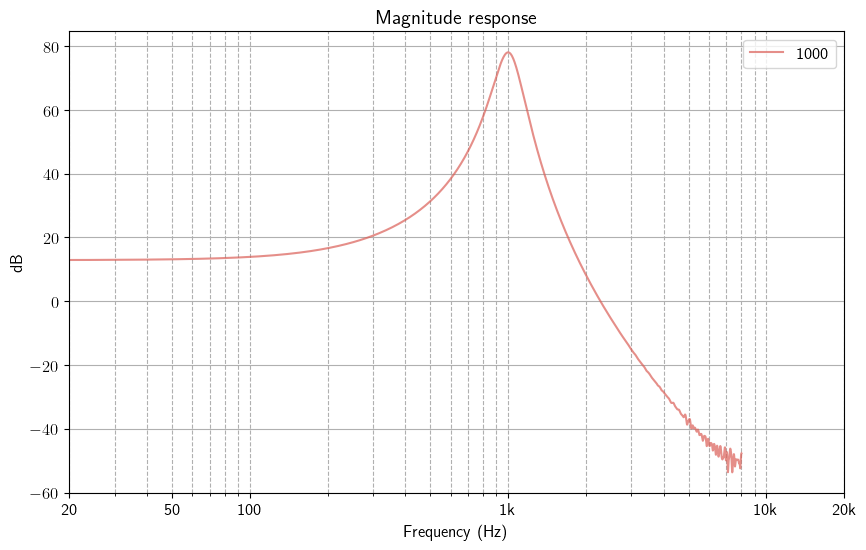

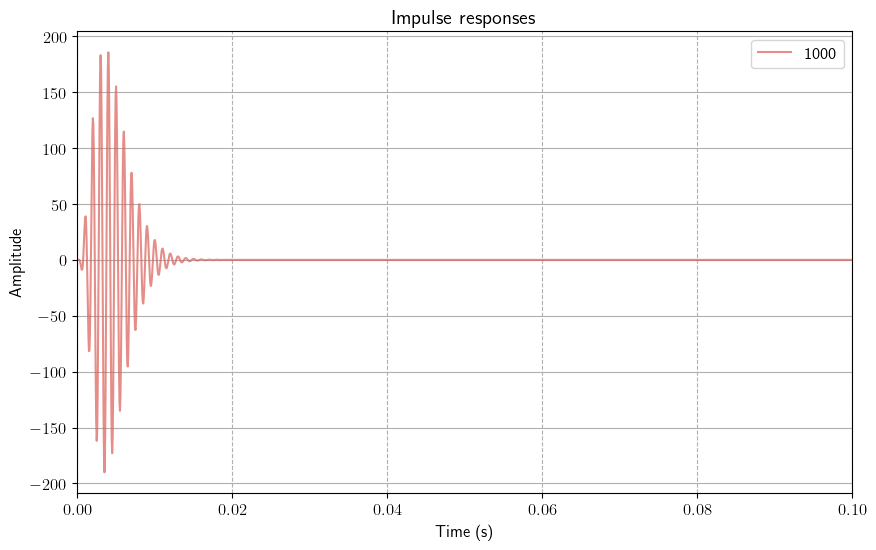

Impaired filterbank


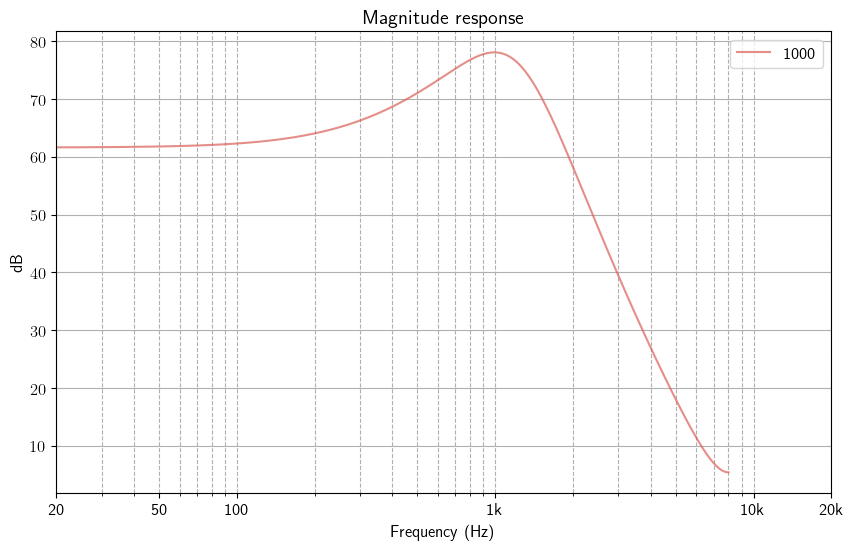

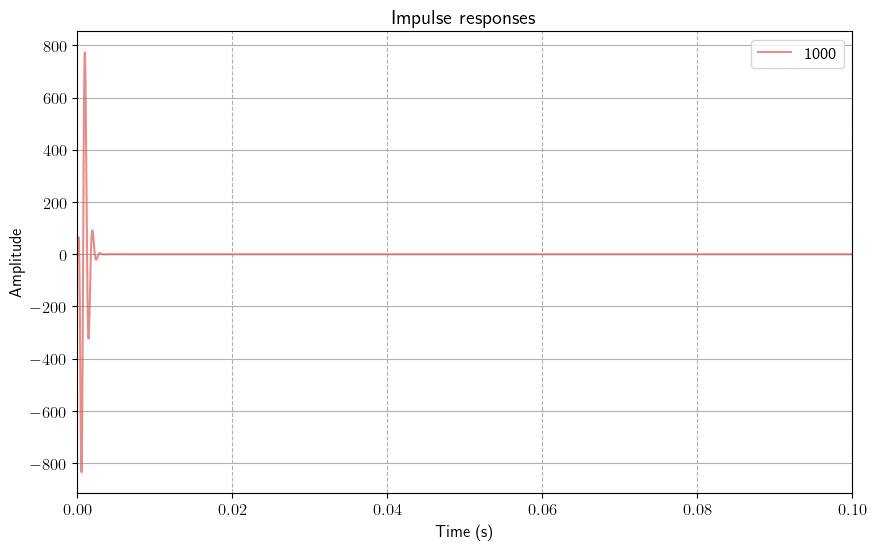

In [65]:
# initiate a normal hearing gammatone filterbank
filterbank_NH = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    delta_q=0,
)

# initiate a impaired gammatone filterbank
filterbank_HI = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    delta_q=5,
)


print("Normal hearing filterbank")
plot_gammabank(filterbank_NH,center_frequencies=center_frequencies)
print("Impaired filterbank")
plot_gammabank(filterbank_HI,center_frequencies=center_frequencies)

In [56]:
import torch.optim as optim

model = MyModel_v1(
    num_taps=64,
    samplerate=samplerate, 
    center_frequencies=center_frequencies,
    delta_q=5,
)

print(model)
print(model.parameters())

for param in model.parameters():
    print(param.shape)

MyModel_v1(
  (normal_model): HearingModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0): GammaToneFilter()
      )
    )
  )
  (impaired_model): HearingModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0): GammaToneFilter()
      )
    )
  )
  (hearing_aid_model): FIRFilter1D()
)
<generator object Module.parameters at 0x0000013157477450>
torch.Size([64, 1])


input audio


normal hearing  output


impaired output


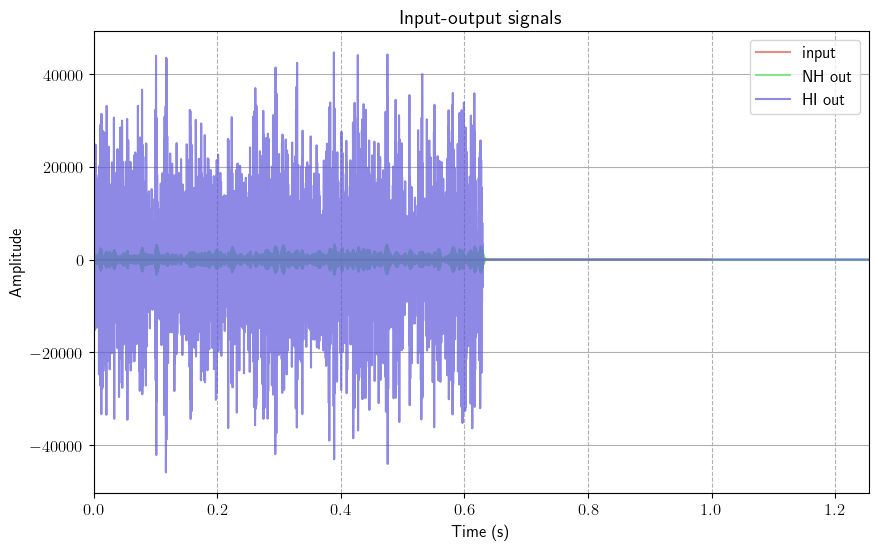

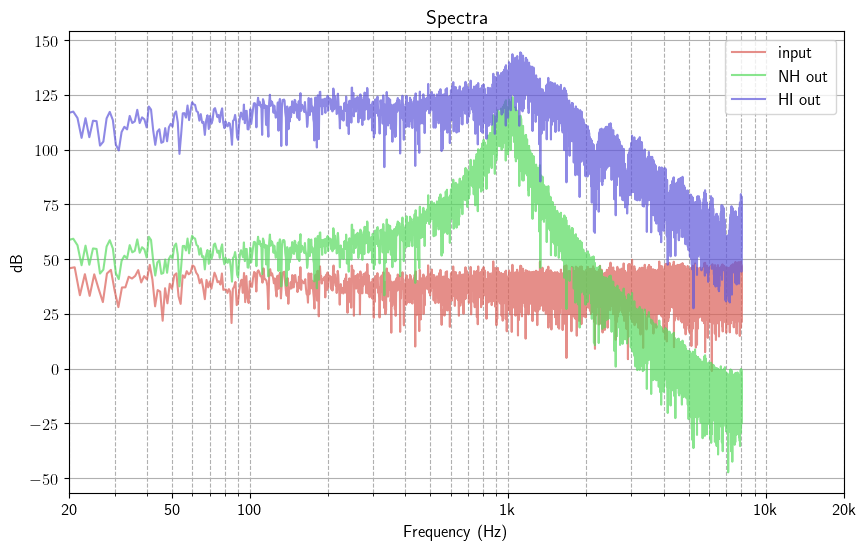

In [57]:
x_noise = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_noise[:,:,10000:] = 0.0  # Input of length 10, all zeros
x_d = torch.zeros(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_d[:, :, 0:1000] = 1.0  # Impulse

# choose which signal to excite with
x = x_noise

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)


signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])


input audio


normal hearing  output


impaired output


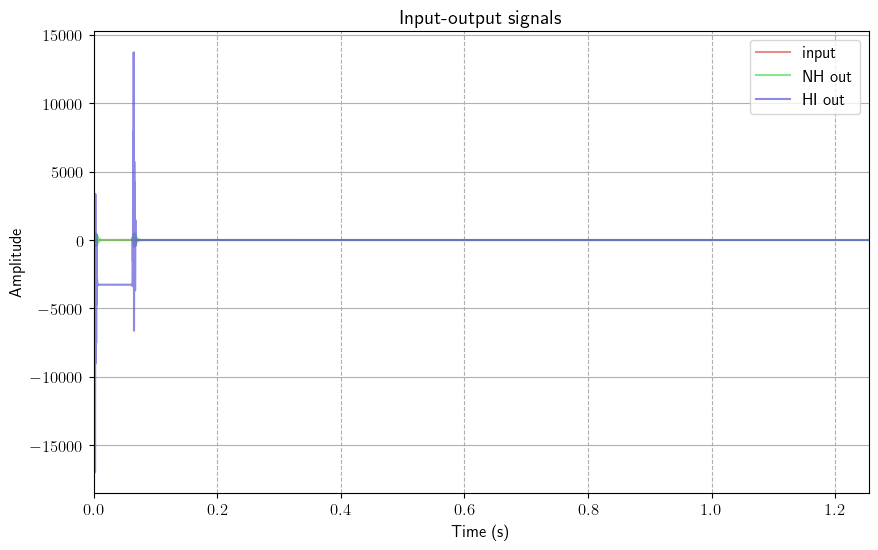

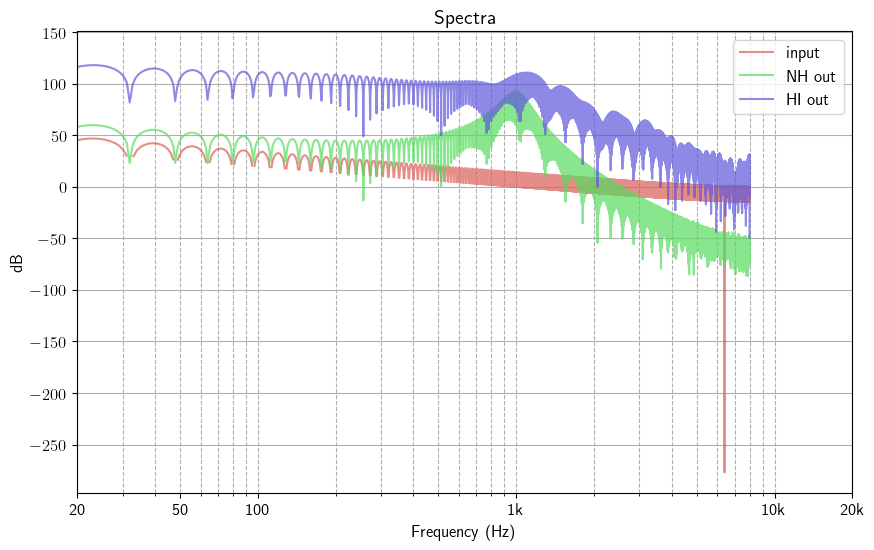

In [58]:
# choose which signal to excite with
x = x_d

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)

signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])



In [59]:
import torch.optim as optim
from torchmetrics import ScaleInvariantSignalDistortionRatio


input_data = x_noise # a noise pulse

# Loss function and optimizer
criterion = ScaleInvariantSignalDistortionRatio()
# criterion = nn.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Dummy training loop
num_epochs = 200
for epoch in range(num_epochs):
    total_loss = 0.0

    # Forward pass and compute loss
    out_NH, out_HI = model(input_data)
    loss = -criterion(out_HI,out_NH)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

# Optionally, you can save the trained model
torch.save(model.state_dict(), r'..\models\v1_ntrain1100')

Epoch 1/200, Loss: 4.100577354431152
Epoch 2/200, Loss: 3.404860019683838
Epoch 3/200, Loss: 2.2151644229888916
Epoch 4/200, Loss: 0.7613081336021423
Epoch 5/200, Loss: -0.7566956281661987
Epoch 6/200, Loss: -2.1728904247283936
Epoch 7/200, Loss: -3.3498051166534424
Epoch 8/200, Loss: -4.197627067565918
Epoch 9/200, Loss: -4.706935405731201
Epoch 10/200, Loss: -4.946993350982666
Epoch 11/200, Loss: -5.019308090209961
Epoch 12/200, Loss: -5.01161003112793
Epoch 13/200, Loss: -4.981179237365723
Epoch 14/200, Loss: -4.958733558654785
Epoch 15/200, Loss: -4.95756196975708
Epoch 16/200, Loss: -4.98101806640625
Epoch 17/200, Loss: -5.027268409729004
Epoch 18/200, Loss: -5.092017650604248
Epoch 19/200, Loss: -5.1700286865234375
Epoch 20/200, Loss: -5.2559709548950195
Epoch 21/200, Loss: -5.344910621643066
Epoch 22/200, Loss: -5.432598114013672
Epoch 23/200, Loss: -5.515645980834961
Epoch 24/200, Loss: -5.591612815856934
Epoch 25/200, Loss: -5.659003257751465
Epoch 26/200, Loss: -5.71720027923

input audio


normal hearing  output


impaired output


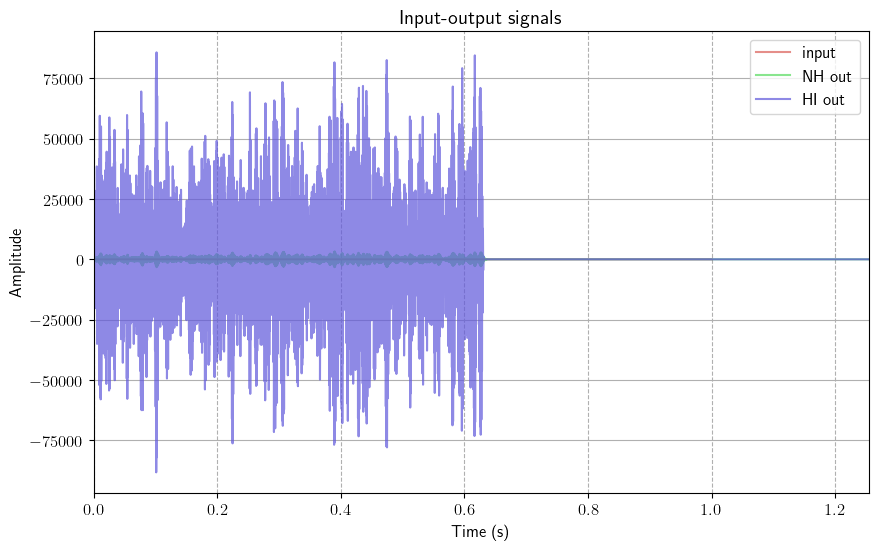

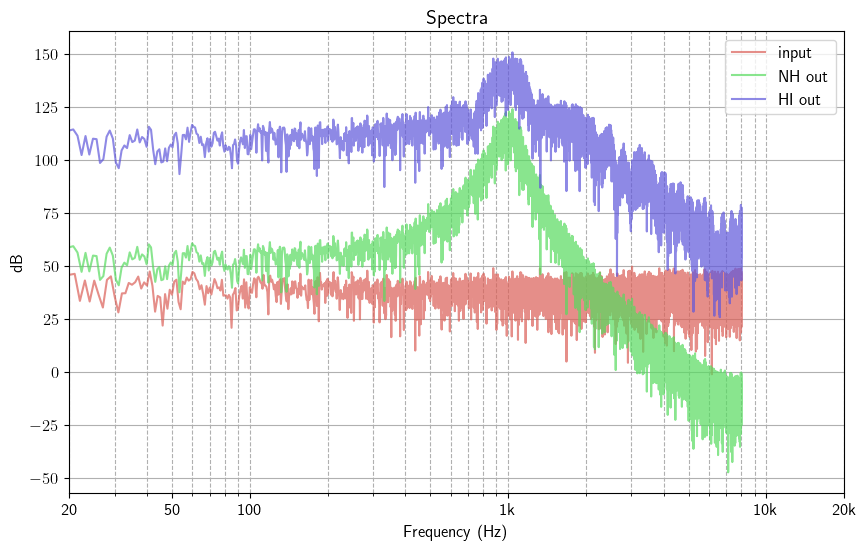

In [60]:
# choose which signal to excite with
x = input_data

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)

signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])

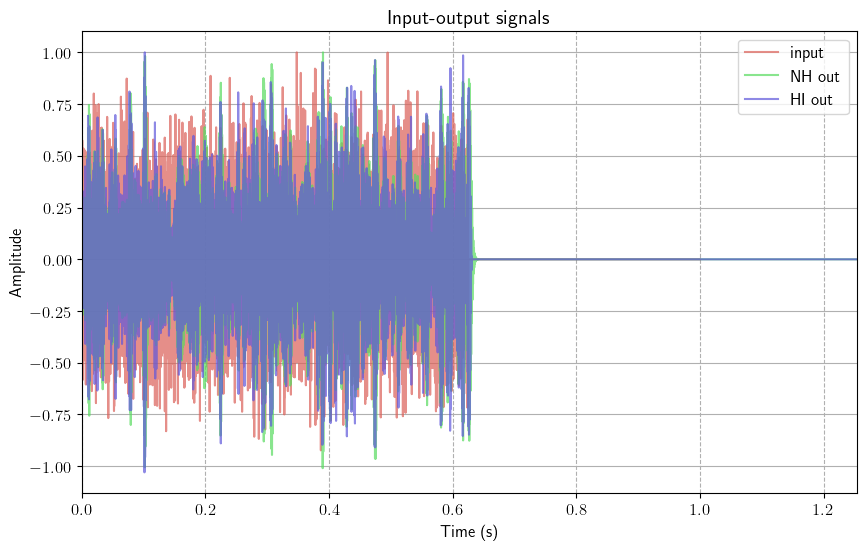

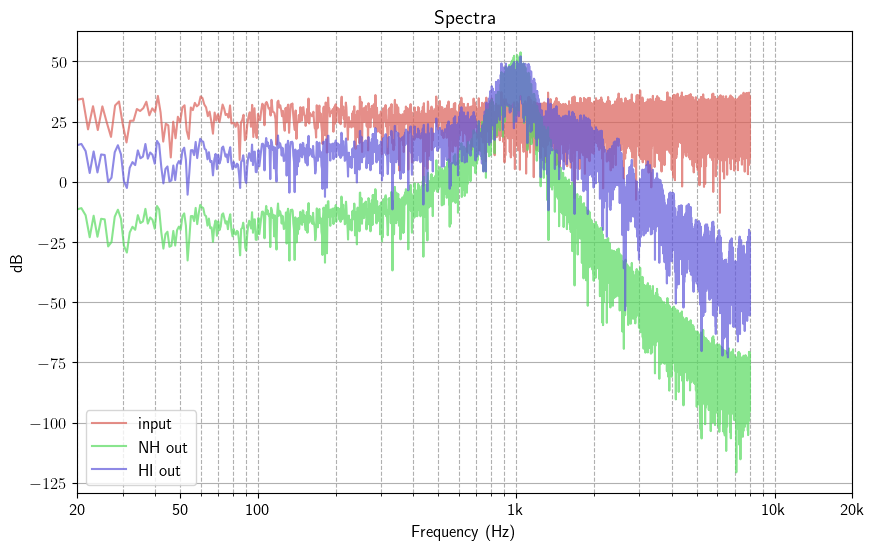

In [61]:
signals = [
    batch_2_np(x) / max(batch_2_np(x)),
    batch_2_np(out_NH) / max(batch_2_np(out_NH)),
    batch_2_np(out_HI) / max(batch_2_np(out_HI)),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])

Inspect predicted filter

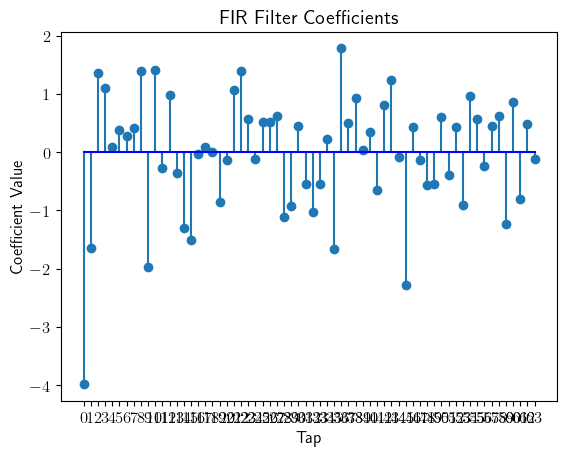

In [62]:
coeffs = model.hearing_aid_model.filter_taps.detach().numpy()
plot.filter_coeffs(coeffs)

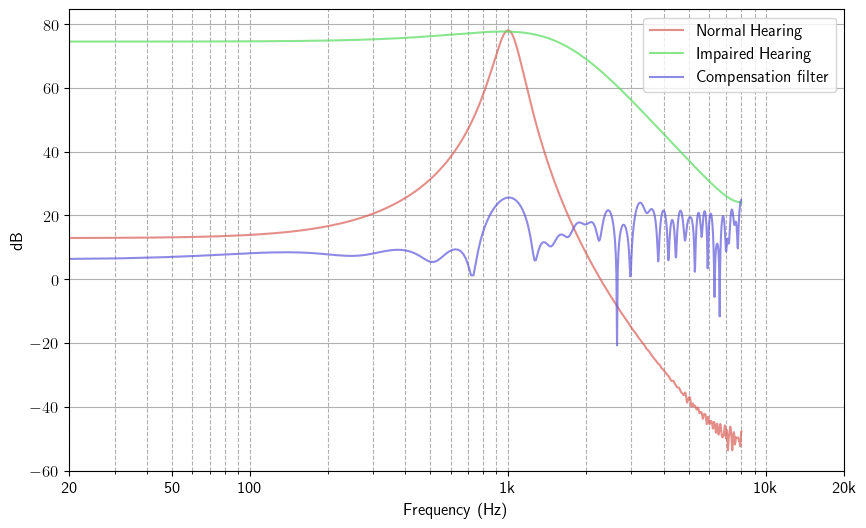

In [63]:
freq_axes = []
spec_axes = []
time_signals = []
    
for filter in filterbank_NH.filters:
    h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter.impulse_response)
for filter in filterbank_HI.filters:
    h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
    freq_axes.append(f)
    spec_axes.append(h)
    time_signals.append(filter.impulse_response)

w, h = signal.freqz(coeffs)
freq_axes.append(w/(2*pi)*samplerate)
spec_axes.append(h)

# Plot IR in time-domain and magnitude repsonse
plot.magspec(
    freq_axes=freq_axes,
    spec_axes=spec_axes,
    labels=["Normal Hearing","Impaired Hearing","Compensation filter"]
)



In [64]:
overlap = .75
win_length = 1024
hop_length = ...
Zxx, f, t = torchaudio.spectrogram(
    n_fft = ,
    win_length = ,
    hop_length = ,
)

SyntaxError: invalid syntax (2466846575.py, line 5)